In [1]:
#Simulating CMB on an ACT-like map

In [2]:
import os
import numexpr as ne
import sys
import cactusLib.cactusUtils as cu
from cactusLib.cactusLib import mapAnalysisObject2 as mao
from cactusLib.cactusCatalogs import readCatalog
import numpy as np
import os
from datetime import datetime
import scipy
from flipper import fftTools
from cactusLib import filterLib
import matplotlib.pyplot as plt
from cactusLib.cactusBeams import getBeamSpline, getBeamNorm
from scipy import ndimage
from cactusLib.filterLib import symmetrizeFFT

import matplotlib.pyplot as plt

/home/cvargas/.local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .circular_overlap import *       # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .elliptical_overlap import *     # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:8: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .rectangular_overlap import *    # noqa


In [3]:
i = 0

In [4]:
paramfile = "./ar2s2.par"
#simrange = [0,1]
outdir = "test_sim_maps_nr"
catname = "./test_sim_cats/"
tag = "ACT_220_s2_sim_full"
if not os.path.isdir(outdir):
    os.makedirs(outdir)
startTime = datetime.now()
ma = mao(paramfile)
mapData = ma.Map.map.data.copy()
#print "Processing sim %d/%d" % (i+1, simrange[1] - simrange[0])

#print "Proccessing sim{}".format(i)

ma.Map.map.data = mapData.copy()

In [5]:
#Start with only CMB

In [6]:
ltmap = ma.Map.map.copy()

In [7]:
FTmap = fftTools.fftFromLiteMap(ltmap)

In [8]:
FTmap.modLMap

array([[  0.        ,   5.64281896,  11.28563793, ...,  16.92845689,
         11.28563793,   5.64281896],
       [ 44.9761477 ,  45.32874659,  46.37045918, ...,  48.05649295,
         46.37045918,  45.32874659],
       [ 89.95229539,  90.12911212,  90.65749318, ...,  91.53135036,
         90.65749318,  90.12911212],
       ...,
       [134.92844309, 135.04638522, 135.39959519, ..., 135.98623977,
        135.39959519, 135.04638522],
       [ 89.95229539,  90.12911212,  90.65749318, ...,  91.53135036,
         90.65749318,  90.12911212],
       [ 44.9761477 ,  45.32874659,  46.37045918, ...,  48.05649295,
         46.37045918,  45.32874659]])

In [9]:
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)

#ell, DlTT = np.loadtxt("camb_73434134_scalcls.dat", usecols=(0, 1), unpack=True)


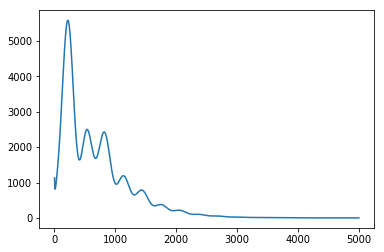

In [10]:
plt.plot(ell,DlTT)

In [11]:
ell

array([2.000e+00, 3.000e+00, 4.000e+00, ..., 4.998e+03, 4.999e+03,
       5.000e+03])

In [12]:
#From DlTT to ClTT

ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))

# set the monopole and the dipole of the Cl spectrum to zero
ell = np.delete(ell,0)
ell = np.delete(ell,0)
ClTT = np.delete(ClTT,0)
ClTT = np.delete(ClTT,0)

#Taking square root, interpolating and applying to modLmap

sClTT = np.sqrt(ClTT)

sCl = scipy.interpolate.InterpolatedUnivariateSpline(ell,sClTT,ext=1.)


In [13]:
FTmap.modLMap

array([[  0.        ,   5.64281896,  11.28563793, ...,  16.92845689,
         11.28563793,   5.64281896],
       [ 44.9761477 ,  45.32874659,  46.37045918, ...,  48.05649295,
         46.37045918,  45.32874659],
       [ 89.95229539,  90.12911212,  90.65749318, ...,  91.53135036,
         90.65749318,  90.12911212],
       ...,
       [134.92844309, 135.04638522, 135.39959519, ..., 135.98623977,
        135.39959519, 135.04638522],
       [ 89.95229539,  90.12911212,  90.65749318, ...,  91.53135036,
         90.65749318,  90.12911212],
       [ 44.9761477 ,  45.32874659,  46.37045918, ...,  48.05649295,
         46.37045918,  45.32874659]])

In [14]:
ell2 = np.linspace(0.,20000.,100000)
cl2 = sCl(ell2)

(0.0, 0.5)

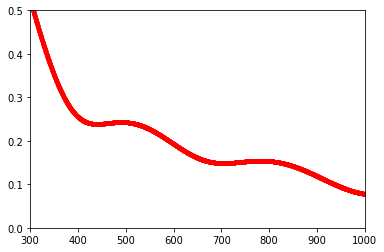

In [15]:
plt.plot(ell2,sCl(ell2),"r.")
plt.xlim(300.,1000.)
plt.ylim(0.,0.5)

In [16]:
Pure_CMB = sCl(FTmap.modLMap)

In [17]:
random_realization_real = np.random.normal(0.,1.,(FTmap.Ny,FTmap.Nx))
random_realization_FFT = np.fft.fft2(random_realization_real)
random_exp = np.exp(1j*np.angle(random_realization_FFT))

CMB = Pure_CMB*random_exp

CMB = np.fft.ifft2(CMB)
CMB = np.real(CMB)*(np.sqrt(FTmap.kMap.size)/np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY))

In [18]:
np.sum(Pure_CMB**2)

1965.1463343610985

In [19]:
np.sum((CMB*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY))**2)

1965.1463343610976

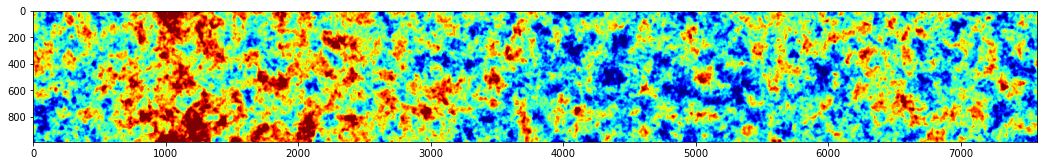

In [20]:
plt.figure(figsize=(18,10))
plt.imshow(CMB,vmin=-250,vmax=250,cmap="jet")

(array([1.55000e+02, 3.54000e+02, 7.47000e+02, 2.55000e+03, 8.43700e+03,
        2.24490e+04, 5.15790e+04, 1.08010e+05, 2.00911e+05, 3.23441e+05,
        4.82771e+05, 6.56516e+05, 8.17818e+05, 8.97224e+05, 8.96710e+05,
        8.14640e+05, 6.96302e+05, 5.35850e+05, 3.77627e+05, 2.47409e+05,
        1.54085e+05, 9.06170e+04, 5.63200e+04, 3.29470e+04, 1.73180e+04,
        7.74100e+03, 3.52000e+03, 6.91000e+02, 2.85000e+02, 1.66000e+02]),
 array([-479.43376354, -445.88455453, -412.33534553, -378.78613652,
        -345.23692751, -311.68771851, -278.1385095 , -244.58930049,
        -211.04009149, -177.49088248, -143.94167347, -110.39246447,
         -76.84325546,  -43.29404645,   -9.74483745,   23.80437156,
          57.35358057,   90.90278957,  124.45199858,  158.00120759,
         191.55041659,  225.0996256 ,  258.64883461,  292.19804361,
         325.74725262,  359.29646163,  392.84567063,  426.39487964,
         459.94408865,  493.49329765,  527.04250666]),
 <a list of 30 Patch objects>

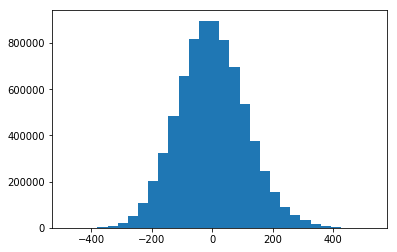

In [21]:
plt.hist(CMB.flatten(),30)

In [22]:
CMB_FTmap = np.fft.fft2(CMB)*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)

In [23]:
mL = FTmap.modLMap

In [24]:
#Recover the CMB signal

In [25]:
np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)

0.0001439659664188118

In [26]:
lt = ltmap.copy()

mu = 0.
sigma = 1.
Ny,Nx = lt.data.shape
new = np.fft.fft2(np.random.normal(mu,sigma,(Ny,Nx)))
new_exp = new/np.abs(new)

lt = ma.Map.map.copy()
lt.data[:] = lt.data*np.sqrt(ma.Map.weights.data)

noiseMap = lt.copy()

pad = 40
extraYPad = 0
apodNy,apodNx = noiseMap.data.shape
apod = np.zeros((apodNy,apodNx))
apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
N_apod = scipy.ndimage.gaussian_filter(apod,80,mode="constant")

In [27]:
#N_apod[:] = 1.0

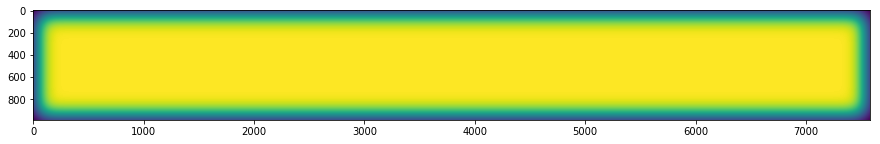

In [28]:
plt.figure(figsize=(15,10))
plt.imshow(N_apod)

In [29]:
CMB_apod = CMB*N_apod


In [30]:
f = np.sqrt(Nx*Ny)/(np.sqrt(np.sum(np.abs(N_apod)**2)))
print f

1.115652775601516


In [31]:
np.sqrt(np.sum(np.abs(np.fft.fft2(CMB))**2)/np.sum(np.abs(np.fft.fft2(CMB_apod))**2))

1.1271735969025451

In [32]:
f = np.sqrt(np.sum(np.abs(CMB)**2)/np.sum(np.abs(CMB_apod)**2))


In [33]:
CMB_FT = np.fft.fft2(f*CMB_apod)*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)

In [34]:
smooth = scipy.ndimage.gaussian_filter(np.abs(np.fft.fftshift(CMB_FT)),sigma=2.0)
smooth = np.fft.ifftshift(smooth)

In [35]:
np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)

5.255075879569508e-08

In [36]:
#%matplotlib auto

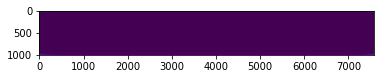

In [37]:
plt.imshow(smooth)

In [38]:
FTmap.lx

array([  0.        ,   5.64281896,  11.28563793, ..., -16.92845689,
       -11.28563793,  -5.64281896])

In [39]:
bins = np.linspace(300,3500.,80)

In [40]:
bins

array([ 300.        ,  340.50632911,  381.01265823,  421.51898734,
        462.02531646,  502.53164557,  543.03797468,  583.5443038 ,
        624.05063291,  664.55696203,  705.06329114,  745.56962025,
        786.07594937,  826.58227848,  867.08860759,  907.59493671,
        948.10126582,  988.60759494, 1029.11392405, 1069.62025316,
       1110.12658228, 1150.63291139, 1191.13924051, 1231.64556962,
       1272.15189873, 1312.65822785, 1353.16455696, 1393.67088608,
       1434.17721519, 1474.6835443 , 1515.18987342, 1555.69620253,
       1596.20253165, 1636.70886076, 1677.21518987, 1717.72151899,
       1758.2278481 , 1798.73417722, 1839.24050633, 1879.74683544,
       1920.25316456, 1960.75949367, 2001.26582278, 2041.7721519 ,
       2082.27848101, 2122.78481013, 2163.29113924, 2203.79746835,
       2244.30379747, 2284.81012658, 2325.3164557 , 2365.82278481,
       2406.32911392, 2446.83544304, 2487.34177215, 2527.84810127,
       2568.35443038, 2608.86075949, 2649.36708861, 2689.87341

In [41]:
mL = FTmap.modLMap

In [42]:
Cl = []
ell = []
for i in range(len(bins)-1):
    c1 = mL>bins[i]
    c2 = mL<bins[i+1]
    c = c1.astype(int)*c2.astype(int)
    c = c.astype(bool)
    #Clbin = np.mean(smooth[c])
    CMB_FT_abs = np.abs(CMB_FT)
    Clbin = np.mean(CMB_FT_abs[c])
    lbin = np.mean(FTmap.modLMap[c])
    #lbin = np.mean([bins[i],bins[i+1]])
    #print lbin
    Cl.append(Clbin)
    ell.append(lbin)
    

(0.0, 0.4)

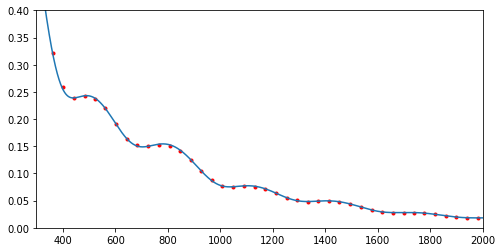

In [43]:
plt.figure(figsize=(8,4))
plt.plot(ell,Cl,"r.")

plt.plot(ell2,cl2)

CMB_FT_abs[c]

plt.xlim(bins[0],2000.)
plt.ylim(0.,0.4)


(0.0, 0.1)

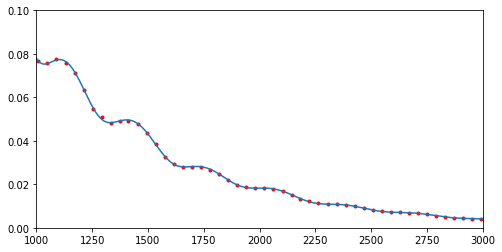

In [44]:
plt.figure(figsize=(8,4))
plt.plot(ell,Cl,"r.")

plt.plot(ell2,cl2)

CMB_FT_abs[c]

plt.xlim(1000.,3000.)
plt.ylim(0.,0.1)


(-0.0025, 0.0025)

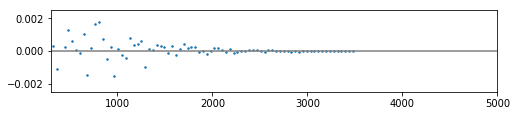

In [45]:
plt.figure(figsize=(8,1.5))
diff = sCl(ell)-Cl
plt.plot(ell,diff,".",markersize=3.)
plt.ylim(-0.01,0.01)

x0 = np.linspace(300.,5000.)
y0 = x0*0.
plt.plot(x0,y0,color="gray")

plt.xlim(300.,5000.)
plt.ylim(-0.0025,0.0025)

#np.mean(diff)

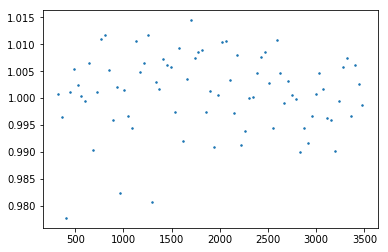

In [46]:
div = sCl(ell)/Cl
plt.plot(ell,div,".",markersize=3.)
#plt.ylim(-0.01,0.01)

#x0 = np.linspace(300.,3000.)
#y0 = x0*0.
#plt.plot(x0,y0,color="gray")

#plt.xlim(1000.,3000.)
#plt.ylim(-0.0025,0.0025)

In [47]:
np.mean(div)

1.0010505345630816